<a href="https://colab.research.google.com/github/wanderingxplorer1/ml-projects/blob/main/movie-recommendations/MovieRecommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Dot, Flatten, IntegerLookup, Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
from keras import regularizers
import tensorflow_datasets as tfds
from keras import initializers
import os
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
import io

# Download the MovieLens full dataset

In [ ]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'

path_to_downloaded_file = tf.keras.utils.get_file("ml-latest.zip", url, extract=True)
print(path_to_downloaded_file)
dataset_dir = os.path.join(os.path.dirname(path_to_downloaded_file), 'ml-latest')
print(dataset_dir)
ratings_dir = os.path.join(dataset_dir, "ratings.csv")
movies_dir = os.path.join(dataset_dir, "movies.csv")

350896731/350896731 [==============================] - 6s 0us/step
/root/.keras/datasets/ml-latest.zip
/root/.keras/datasets/ml-latest


# Transform the movie dataset
Examine the movies dataset. It seems the movie ids are not continuous numbers, but sparse integers. We will map them to new ids using integer_lookup into a new set of ids to use in the embedding matrix.

In [ ]:
import pandas as pd
df_movies = pd.read_csv(movies_dir)
integer_lookup = IntegerLookup(name="movieId Lookup")
integer_lookup.adapt(df_movies["movieId"])
df_movies["movieIdDense"] = integer_lookup(df_movies["movieId"])
df_movies

,movieId,title,genres,movieIdDense
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,86537
1,2,Jumanji (1995),Adventure|Children|Fantasy,86536
2,3,Grumpier Old Men (1995),Comedy|Romance,86535
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,86534
4,5,Father of the Bride Part II (1995),Comedy,86533
...,...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),Action|Drama,5
86533,288971,Ouija Japan (2021),Action|Horror,4
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,3
86535,288977,Skinford: Death Sentence (2023),Crime|Thriller,2


# Look at the ratings dataset
We will add the same dense movie id that we created earlier to this so that we can use these during training.

In [ ]:
df_ratings = pd.read_csv(ratings_dir)

# # Likes
# new_row = {'userId': 611, 'movieId': 110, 'rating': 5.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 150, 'rating': 5.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 296, 'rating': 5.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 608, 'rating': 5.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 231, 'rating': 5.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row

# # OK ones
# new_row = {'userId': 611, 'movieId': 1380, 'rating': 3.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 2529, 'rating': 2.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 3114, 'rating': 2.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 4105, 'rating': 1.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row
# new_row = {'userId': 611, 'movieId': 179401, 'rating': 2.0, 'timestamp': 964982703}
# df_ratings.loc[len(df_ratings)] = new_row



In [ ]:
df_ratings["movieIdDense"] = integer_lookup(df_ratings["movieId"])
df_ratings

,userId,movieId,rating,timestamp,movieIdDense
0,1,1,4.0,1225734739,86537
1,1,110,4.0,1225865086,86429
2,1,158,4.0,1225733503,86381
3,1,260,4.5,1225735204,86280
4,1,356,5.0,1225735119,86186
...,...,...,...,...,...
33832157,330975,8340,2.0,1091583256,78804
33832158,330975,8493,2.5,1091585709,78714
33832159,330975,8622,4.0,1091581777,78626
33832160,330975,8665,3.0,1091581765,78583


In [ ]:
NUM_RATINGS = df_ratings["userId"].size
NUM_USERS=df_ratings["userId"].nunique()
NUM_MIN_USER_ID = df_ratings["userId"].min()
NUM_MAX_USER_ID = df_ratings["userId"].max()

NUM_MOVIES = df_movies["movieId"].nunique()
NUM_MIN_MOVIE_ID = df_movies["movieId"].min()
NUM_MAX_MOVIE_ID = df_movies["movieId"].max()
ALL_MOVIE_IDS = df_movies['movieIdDense'].unique()

330975 1 330975
86537 1 288983
Number users,movies,ratings: 330975 86537 33832162
[86537 86536 86535 86534 86533 86532 86531 86530 86529 86528]


# Build and train the model

In [ ]:
train, test = train_test_split(df_ratings, test_size=0.2)
ROW_COUNT = train.shape[0]
train.head()

,userId,movieId,rating,timestamp,movieIdDense
19400496,189884,8477,4.0,1228836429,78727
15425805,151625,1432,3.0,1048425369,85144
21039482,205511,922,5.0,914697968,85636
32942017,322128,2115,4.0,1111500358,84512
20402802,199194,628,4.0,1108669153,85919


In [ ]:
def build_model(num_users, num_movies, embedding_dim):
  movie_input = Input(shape=(1,), name="movie_id")
  movie_emb = Embedding(input_dim=num_movies+1, output_dim=embedding_dim,
                        name='movie_emb')(movie_input)
  movie_vec = Flatten(name='flatten_movie')(movie_emb)
  movie_model = Model(inputs=movie_input, outputs=movie_vec)


  user_input = Input(shape=(1,), name="user_id")
  user_emb = Embedding(input_dim=num_users+1, output_dim=embedding_dim,
                      name='user_emb')(user_input)
  user_vec = Flatten(name='flatten_user')(user_emb)
  user_model = Model(inputs=user_input, outputs=user_vec)

  x = Dot(name = 'dot_product', normalize=True, axes=2)([movie_emb, user_emb])
  x = Dense(70, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(20, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  result = Dense(1, activation=None)(x)
  model = Model([movie_input, user_input], result)
  return model, movie_model, user_model

In [ ]:
# Embedding dimension should be around the 4th root of vacab (~86000 movies)
EMBEDDING_DIM = 20
model, movie_model, user_model = build_model(NUM_USERS, NUM_MOVIES, EMBEDDING_DIM)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='mean_absolute_error')
model.summary()
plot_model(model, show_shapes=True)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 movie_emb (Embedding)       (None, 1, 20)                1730760   ['movie_id[0][0]']            
                                                                                                  
 user_emb (Embedding)        (None, 1, 20)                6619520   ['user_id[0][0]']             
                                                                                           

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping('val_loss', patience=10)]

history = model.fit([train.movieIdDense, train.userId],train.rating, batch_size=100000,
                              epochs=50, validation_data = ([test.movieIdDense, test.userId],test.rating),
                              verbose=1,
                              callbacks = callbacks)

Epoch 1/50
271/271 [==============================] - 40s 136ms/step - loss: 1.6701 - val_loss: 0.6961
Epoch 2/50
271/271 [==============================] - 19s 71ms/step - loss: 0.6806 - val_loss: 0.6427
Epoch 3/50
271/271 [==============================] - 13s 46ms/step - loss: 0.6228 - val_loss: 0.6250
Epoch 4/50
271/271 [==============================] - 10s 36ms/step - loss: 0.5895 - val_loss: 0.6169
Epoch 5/50
271/271 [==============================] - 7s 24ms/step - loss: 0.5698 - val_loss: 0.6185
Epoch 6/50
271/271 [==============================] - 5s 20ms/step - loss: 0.5534 - val_loss: 0.6224
Epoch 7/50
271/271 [==============================] - 6s 22ms/step - loss: 0.5423 - val_loss: 0.6241
Epoch 8/50
271/271 [==============================] - 5s 19ms/step - loss: 0.5344 - val_loss: 0.6230
Epoch 9/50
271/271 [==============================] - 5s 18ms/step - loss: 0.5276 - val_loss: 0.6211
Epoch 10/50
271/271 [==============================] - 5s 17ms/step - loss: 0.5219 - v

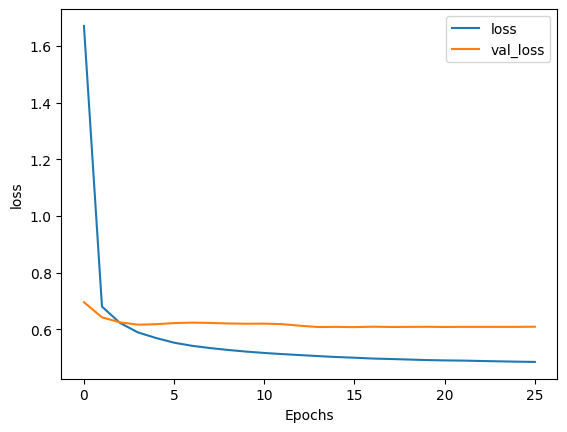

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "loss")

In [ ]:
# Print a user embedding
user_model.predict([np.array([10, 610])])

1/1 [==============================] - 0s 38ms/step


array([[-0.0336437 ,  0.10788807, -0.1220488 ,  0.11904299,  0.00122802,
         0.12500028,  0.12226481, -0.13171187,  0.06866362,  0.09390002,
         0.01270883, -0.19898133,  0.05637091,  0.154332  , -0.08425758,
        -0.06362574, -0.0284611 ,  0.03394361, -0.15236185,  0.02240211],
       [ 0.07268537, -0.07512264, -0.00324006,  0.02684549,  0.1358248 ,
        -0.03719952, -0.00697671,  0.01273906,  0.05302093,  0.0950996 ,
        -0.08438011,  0.17109847, -0.051029  ,  0.0818015 , -0.054361  ,
         0.04859556, -0.04008726, -0.05585803, -0.00309266, -0.15923063]],
      dtype=float32)

# Generate vector and metadata files for embedding visualization of the movies

In [ ]:
# Generate files for embedding visualization
movie_embeddings = movie_model.predict(np.array(ALL_MOVIE_IDS))
embedding_columns = ['e'+str(i) for i in range(EMBEDDING_DIM)]
df_movie_embedding = pd.DataFrame(
    movie_embeddings,
    columns=embedding_columns)
result = pd.concat([df_movies, df_movie_embedding], axis=1)

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for index, row in result.iterrows():
  row_embeddings = [str(row[col_name]) for col_name in embedding_columns]
  out_m.write(row['title'] + "\n")
  out_v.write('\t'.join(row_embeddings) + '\n')

out_v.close()
out_m.close()

2705/2705 [==============================] - 3s 1ms/step


# Use the vectors downloaded to look at the embeddings of movies and their nearest neighbors

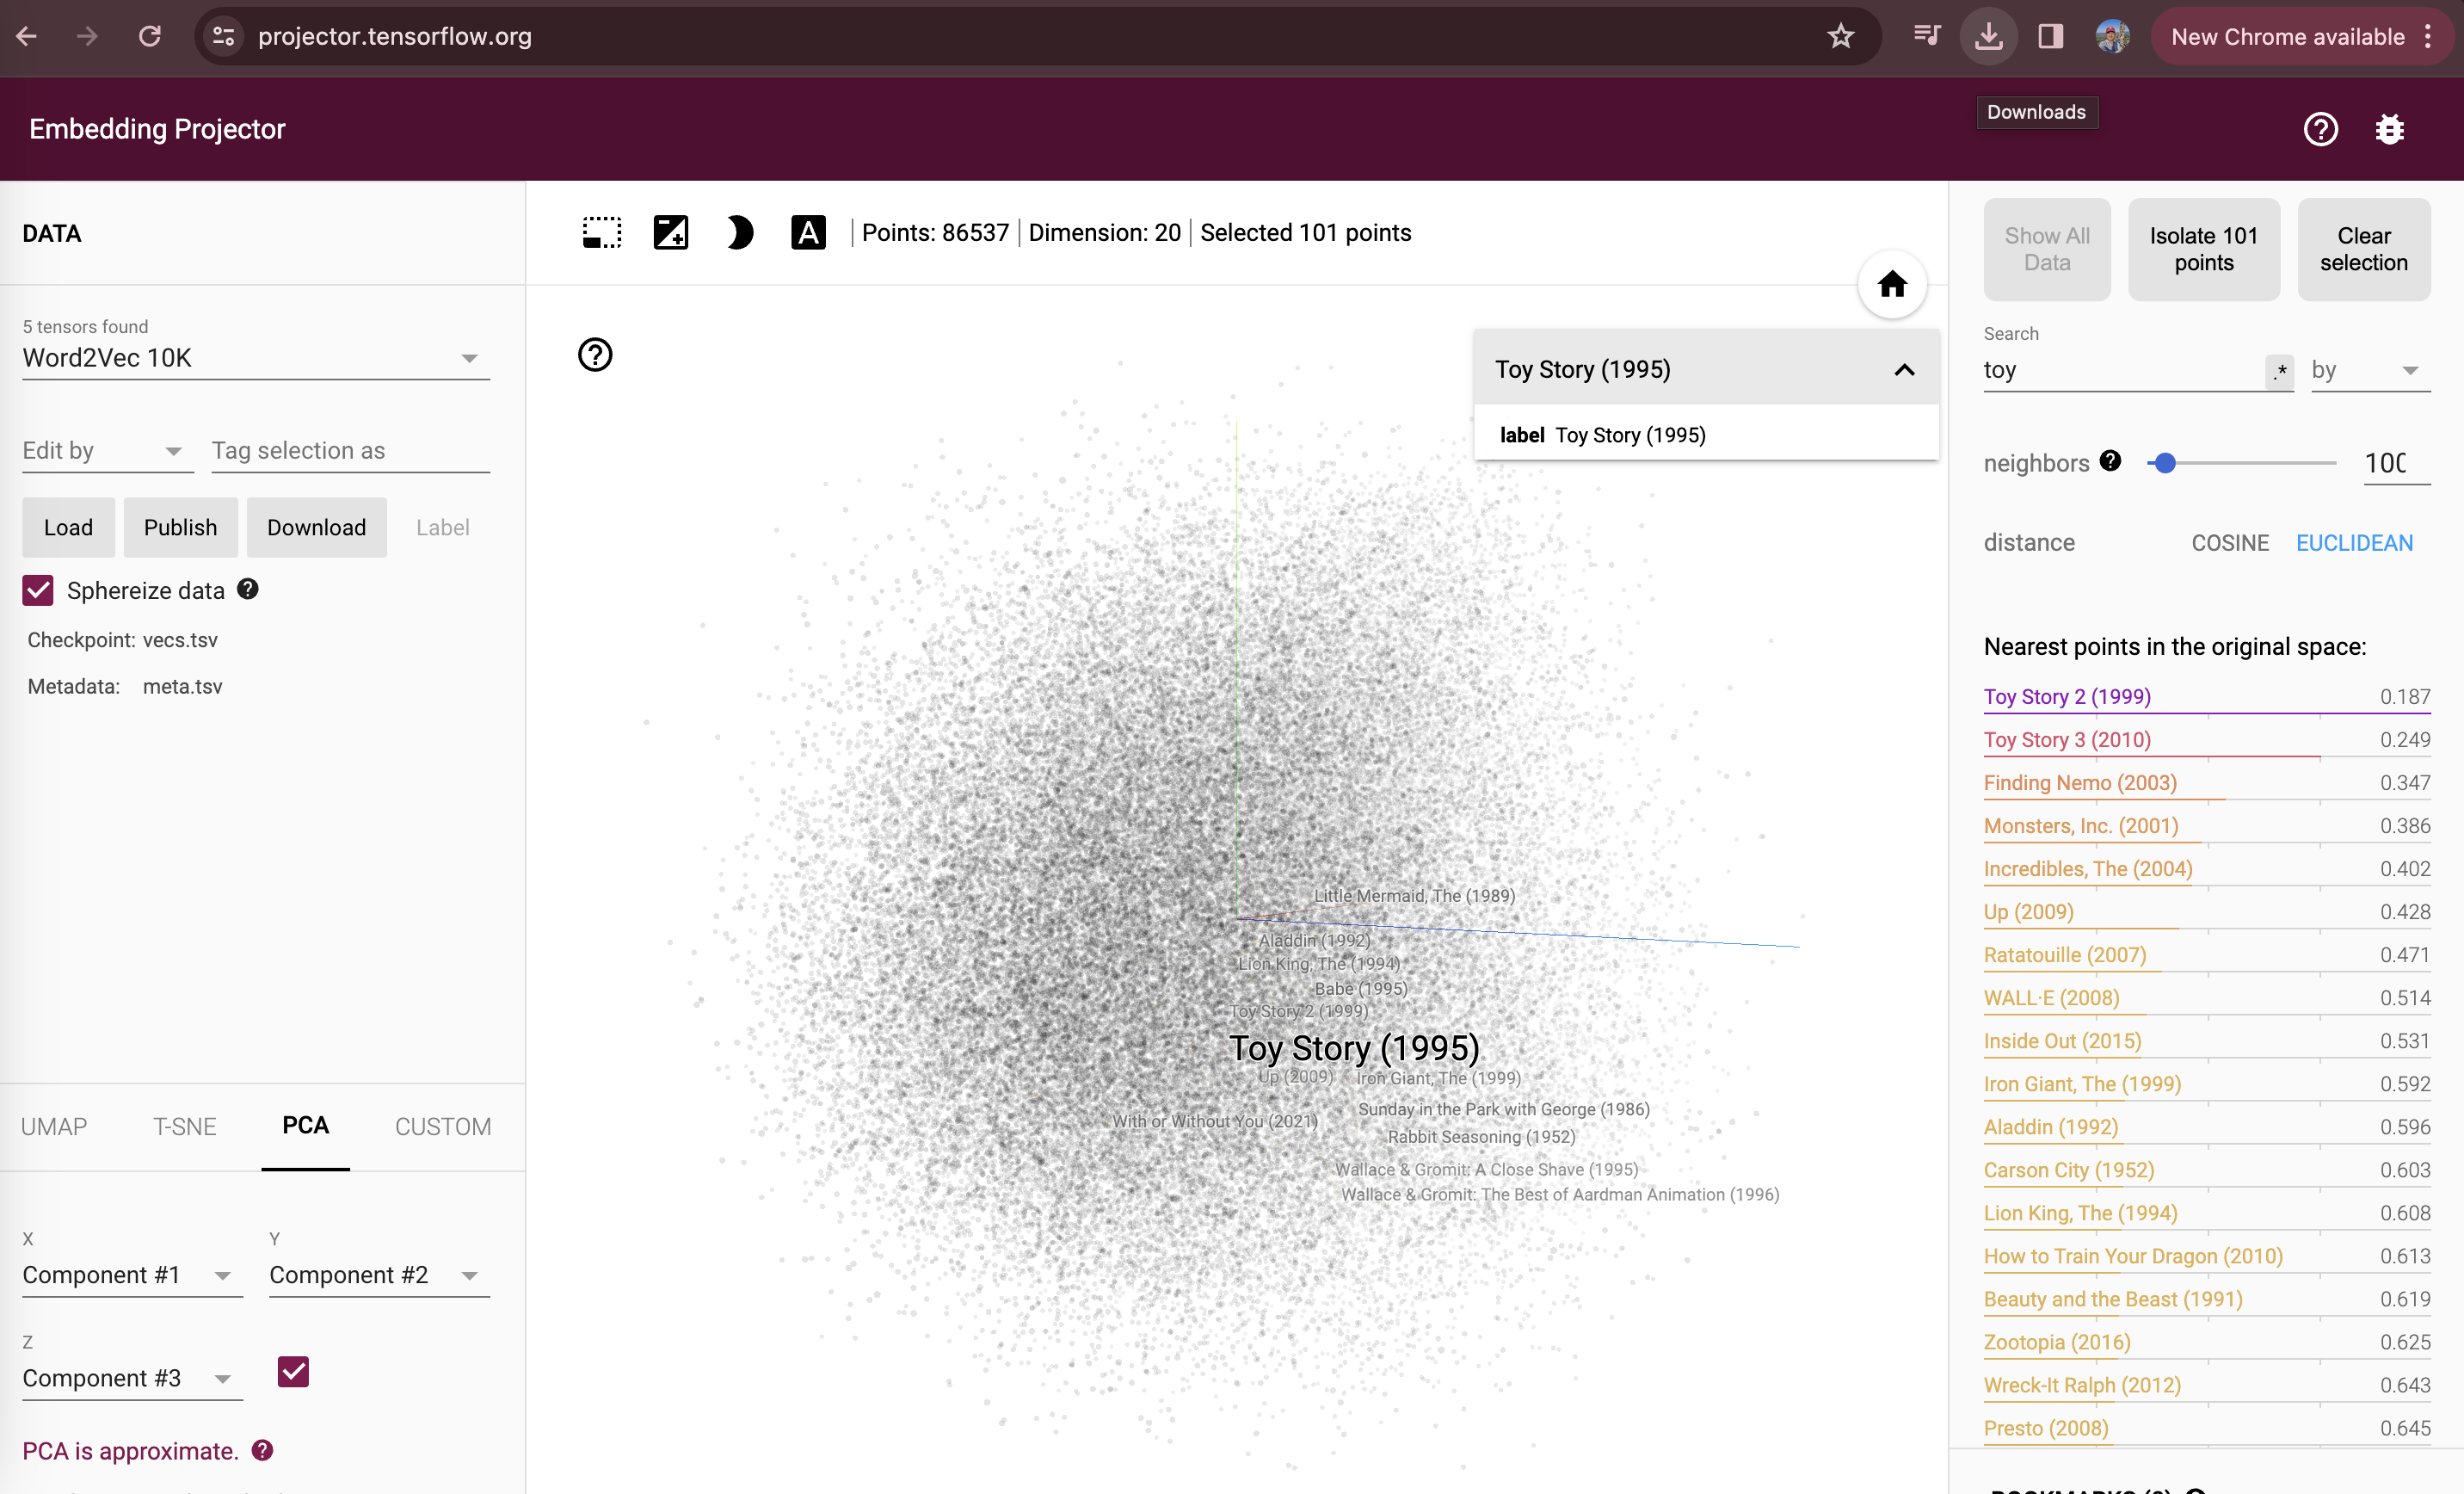

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(movie_embeddings, ALL_MOVIE_IDS)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
def find_nearest_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movieIdDense'])
    return df_indices.merge(df_movies,on='movieIdDense',how='inner',suffixes=['_u', '_m'])['title']

In [ ]:
user_embedding = np.squeeze(user_model.predict([np.array([611])]))
find_nearest_movies(user_embedding)

1/1 [==============================] - 0s 17ms/step


0    Ziggy Stardust and the Spiders from Mars (1973)
1                      Life Without Principle (2011)
2                          The Brave Archer 2 (1978)
3                            Eye of the Tiger (1986)
4                     Funeral for an Assassin (1977)
5                                  MAID-DROID (2008)
6                               Bank Job, The (2008)
7                  Man Who Knew Too Much, The (1956)
8                                      Memory (2006)
9                              Gangster's Boy (1938)
Name: title, dtype: object

In [ ]:
movie_embedding = np.squeeze(user_model.predict([np.array([86537])])) # Toy Story
find_nearest_movies(movie_embedding)

1/1 [==============================] - 0s 18ms/step


0                       Gabrielle (2005)
1     Camp 14: Total Control Zone (2012)
2                Finding Altamira (2016)
3                          Tamara (2005)
4                            Step (2017)
5    Welcome Home Brother Charles (1975)
6                             Ben (1972)
7                           Ghost (2012)
8                   Mike's Murder (1984)
9          Wings of the Dove, The (1997)
Name: title, dtype: object